In [1]:
from artifacts_ipv6_sra_scanning.config import *
import pickle
import os
import ipaddress
import glob
import pycountry_convert as pycc
import country_converter as coco
from parallel_pandas import ParallelPandas
ParallelPandas.initialize(n_cpu=24, split_factor=1, disable_pr_bar=False)

2025-10-08 21:30:18.254 | INFO     | artifacts_ipv6_sra_scanning.config:<module>:22 - PROJ_ROOT path is: /home/service/artifacts-ipv6-sra-scanning


In [2]:
files = glob.glob(f'{INTERIM_DATA_DIR}/*.csv')

In [3]:
files = [file for file in files if 'ixp-ips' not in file]

In [4]:
files

['/home/service/artifacts-ipv6-sra-scanning/data/interim/router-ips.csv',
 '/home/service/artifacts-ipv6-sra-scanning/data/interim/hitlist-ips.csv',
 '/home/service/artifacts-ipv6-sra-scanning/data/interim/itdk-ips.csv',
 '/home/service/artifacts-ipv6-sra-scanning/data/interim/ripe-ips.csv',
 '/home/service/artifacts-ipv6-sra-scanning/data/interim/init-ips-sra-tum-scan.csv',
 '/home/service/artifacts-ipv6-sra-scanning/data/interim/init-ips-sra-bgp48-scan.csv']

In [5]:
info_columns = ['Geo','AS-Number','BGP-Prefix','Org']

In [6]:
ipinfo_asn = pl.read_parquet('/home/service/ipinfos/ipinfo_asn.parquet')

In [7]:
ipinfo_asn = ipinfo_asn.with_columns(pl.col('asn').str.replace('AS','').cast(pl.Float64))

In [8]:
ipinfo_asn

network,asn,domain,name,type,country
str,f64,str,str,str,str
"""1.0.0.0/24""",13335.0,"""cloudflare.com""","""Cloudflare, Inc.""","""hosting""","""US"""
"""1.0.4.0/24""",38803.0,"""gtelecom.com.au""","""Gtelecom Pty Ltd""","""isp""","""AU"""
"""1.0.5.0/24""",38803.0,"""gtelecom.com.au""","""Gtelecom Pty Ltd""","""isp""","""AU"""
"""1.0.6.0/24""",38803.0,"""gtelecom.com.au""","""Gtelecom Pty Ltd""","""isp""","""AU"""
"""1.0.7.0/24""",38803.0,"""gtelecom.com.au""","""Gtelecom Pty Ltd""","""isp""","""AU"""
…,…,…,…,…,…
"""2c0f:ffa8::/32""",37057.0,"""vodacom.co.ls""","""Vodacom Lesotho (Pty) Ltd""","""isp""","""LS"""
"""2c0f:ffc8::/32""",22355.0,"""frogfoot.com""","""Frogfoot Networks""","""isp""","""ZA"""
"""2c0f:ffd0::/32""",36968.0,"""ecn.co.za""","""Electronic Communications Netw…","""isp""","""ZA"""


In [9]:
router_ips = pl.read_csv(files[0])

In [10]:
router_ips = router_ips.filter(pl.col('ip-addr')!='saddr')

In [11]:
router_ips

ip-addr,Geo,AS-Number,BGP-Prefix,Org
str,str,f64,str,str
"""2402:b400:4440:53ef:c822:8bff:…","""MYS""",45960.0,"""2402:b400:4440::/46""","""YTLCOMMS-AS-AP YTL COMMUNICATI…"
"""2003:e6:37ff:3ab2:3ea6:2fff:fe…","""DEU""",3320.0,"""2003::/19""","""DTAG Internet service provider…"
"""2405:8d40:4081:579:1807:c46a:e…","""PHL""",139831.0,"""2405:8d40:4080::/42""","""DTC-AS-AP DITO TELECOMMUNITY C…"
"""240e:358:9c0a:13ec:ae64:62ff:f…","""CHN""",4134.0,"""240e:358::/29""","""CHINANET-BACKBONE No.31,Jin-ro…"
"""2408:8441:5808:10fa:1807:f6b5:…","""CHN""",4837.0,"""2408:8441::/32""","""CHINA169-BACKBONE CHINA UNICOM…"
…,…,…,…,…
"""2409:8a20:680b:c2c:be9e:2cff:f…","""CHN""",56046.0,"""2409:8a20:6800::/40""","""CMNET-JIANGSU-AP China Mobile …"
"""2402:8100:3927:19b:b9dd:7976:1…","""IND""",45271.0,"""2402:8100:3927::/48""","""ICLNET-AS-AP Idea Cellular Lim…"
"""2402:800:620a:485f:a816:567b:4…","""VNM""",7552.0,"""2402:800:620a::/48""","""VIETEL-AS-AP Viettel Group"""


In [12]:
router_asn = router_ips.select(['Geo','AS-Number','ip-addr']).unique()

In [13]:
router_asn = router_asn.join(ipinfo_asn.select(['asn','type']).unique(),how='left',left_on='AS-Number',right_on='asn')

In [14]:
router_asn['type'].value_counts(normalize=True).sort('proportion')

type,proportion
str,f64
"""inactive""",1.5086e-8
"""government""",0.000048
"""education""",0.00018
"""hosting""",0.005616
"""business""",0.009512
null,0.020297
"""isp""",0.964346


In [15]:
router_asn

Geo,AS-Number,ip-addr,type
str,f64,str,str
"""IND""",38266.0,"""2402:3a80:1e13:a619:0:36:8b41:…","""isp"""
"""CHN""",134774.0,"""240e:3b0:320a:2a03:a210:77ff:f…","""hosting"""
"""CHN""",56046.0,"""2409:8a20:9c08:29ed:8e2:cdff:f…","""isp"""
"""DEU""",3209.0,"""2a02:810d:8000:6d:b0cb:637b:76…","""isp"""
"""PER""",12252.0,"""2800:200:e598:517:97e:d5a4:99e…","""isp"""
…,…,…,…
"""IND""",38266.0,"""2402:3a80:4428:c47a:edc3:6b1f:…","""isp"""
"""CHN""",4134.0,"""240e:348:7e04:279a:7626:ffff:f…","""isp"""
"""CHN""",4837.0,"""2408:823c:5400:5c5d:46a3:c7ff:…","""isp"""


In [16]:
router_asn = router_asn.group_by(['Geo','type']).agg(pl.len().alias('count')).sort('count',descending=True)

In [17]:
router_asn

Geo,type,count
str,str,u32
"""IND""","""isp""",35553054
"""CHN""","""isp""",24708845
"""DEU""","""isp""",9246294
"""VNM""","""isp""",8113903
"""USA""","""isp""",6288837
…,…,…
"""JOR""","""business""",1
"""VNM""","""education""",1
"""GMB""","""isp""",1


In [18]:
def map_iso3_to_continent(cc):
    if cc=='XK' or cc=='SXM':
        # kosovo is EU state, count saint marten as EU state (netherland territory)
        return 'EU'
    if cc=='UMI':
        #count umi states as US territory --> NA
        return 'NA'
    if cc=='TLS':
        # timor leste is asian state
        return 'AS'    
    alpha2 = pycc.country_alpha3_to_country_alpha2(cc)
    return pycc.country_alpha2_to_continent_code(alpha2) 

In [19]:
router_asn = router_asn.with_columns(
    pl.col("Geo").map_elements(map_iso3_to_continent, return_dtype=pl.Utf8).alias("Continent")
).filter((pl.col('Geo').is_not_null()) & (pl.col('Geo')!='ATA'))
#filter antarctica values (ATA) --> only 5, not of interest and not very trustworthy imo

In [20]:
router_asn = router_asn.with_columns(pl.col('type').fill_null('Unknown'))

In [21]:
#remove inactive network type as their frequency is negligible with <0.001%
counts = (
    router_asn.filter(pl.col('type')!='inactive').group_by(["Continent", "type"])
      .agg(pl.col('count').sum().alias("continent_count"))
)

rel_freq = (
    counts.with_columns(
        ((pl.col("continent_count") / pl.col("continent_count").sum()).mul(100).round(2).over("Continent")).alias("rel_freq")
    )
)

table = (
    rel_freq.pivot(
        values="rel_freq",
        index="type",
        columns="Continent"
    )
    .fill_null(0.0)  # if some combos are missing
)

/tmp/ipykernel_954628/3030775714.py:14: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.
  rel_freq.pivot(


In [22]:
counts

Continent,type,continent_count
str,str,u32
"""EU""","""Unknown""",21023
"""EU""","""government""",2170
"""SA""","""education""",1685
"""SA""","""Unknown""",63213
"""NA""","""isp""",10004613
…,…,…
"""AF""","""business""",123
"""AS""","""hosting""",442107
"""EU""","""education""",3907


In [23]:
counts.group_by('Continent').agg(pl.col('continent_count').sum()).sort('continent_count',descending=True)

Continent,continent_count
str,u32
"""AS""",87913040
"""EU""",19493180
"""NA""",12486846
"""SA""",12231937
"""OC""",226068
"""AF""",118893


In [24]:
order = counts.group_by('Continent').agg(pl.col('continent_count').sum()).sort('continent_count',descending=True).select('Continent').to_series().to_list()

In [25]:
#order_types = ["ISP", "Hosting", "Business", "Education", "Government", "Inactive", "Unknown"]
#remove inactive network type as their frequency is negligible with <0.001%
order_types = ["ISP", "Hosting", "Business", "Education", "Government", "Unknown"]

In [26]:
table = table.fill_null('Unknown').with_columns(
    pl.when(pl.col("type") == "isp")
      .then(pl.lit("ISP"))  # special case
      .otherwise(
          pl.col("type").str.slice(0,1).str.to_uppercase() + pl.col("type").str.slice(1).str.to_lowercase()
      )
      .alias("type")
).select(['type']+order).with_columns(
    pl.col("type").map_elements(lambda x: order_types.index(x), return_dtype=pl.Int32).alias("_sort_key")
).sort('_sort_key').drop('_sort_key').to_pandas().set_index('type')

In [27]:
table

,AS,EU,NA,SA,OC,AF
type,,,,,,
ISP,97.99,99.02,80.12,98.55,98.58,97.18
Hosting,0.50,0.79,0.28,0.88,1.23,2.17
Business,1.40,0.05,0.11,0.03,0.09,0.10
Education,0.02,0.02,0.02,0.01,0.04,0.44
Government,0.00,0.01,0.00,0.00,0.00,0.00
Unknown,0.08,0.11,19.46,0.52,0.06,0.11


/home/service/artifacts-ipv6-sra-scanning/reports/figures/heatmap-network-types-sra-total.png


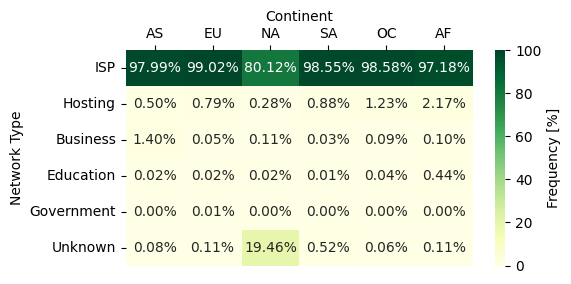

In [28]:
import seaborn as sns
import matplotlib.colors as mpc

figsize = (8*0.7,4*0.7)
fig,ax = vh.fig_ax(figsize)

annot_labels = table.map(lambda x: f"{x:.2f}%")
sns.heatmap(table,fmt="",
            linecolor='white',
            cmap='YlGn',
            annot=annot_labels,
            vmin=0,
            vmax=100,
            ax=ax,
            cbar_kws={'label': 'Frequency [%]',"orientation": "vertical","shrink":1,'location':'right'})
ax.xaxis.tick_top()
ax.set_ylabel('Network Type')
ax.set_xlabel('Continent')
ax.xaxis.set_label_position('top')

vh.save_plot(fig,'heatmap-network-types-sra-total')

In [29]:
print(table.to_latex(float_format="{:.2f}".format))

\begin{tabular}{lrrrrrr}
\toprule
 & AS & EU & NA & SA & OC & AF \\
type &  &  &  &  &  &  \\
\midrule
ISP & 97.99 & 99.02 & 80.12 & 98.55 & 98.58 & 97.18 \\
Hosting & 0.50 & 0.79 & 0.28 & 0.88 & 1.23 & 2.17 \\
Business & 1.40 & 0.05 & 0.11 & 0.03 & 0.09 & 0.10 \\
Education & 0.02 & 0.02 & 0.02 & 0.01 & 0.04 & 0.44 \\
Government & 0.00 & 0.01 & 0.00 & 0.00 & 0.00 & 0.00 \\
Unknown & 0.08 & 0.11 & 19.46 & 0.52 & 0.06 & 0.11 \\
\bottomrule
\end{tabular}

